In [20]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from utils import similar_proteins, c1_c2_c3
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score, average_precision_score
import seaborn as sns

In [21]:
df_prot_list = pd.read_csv('../data/processed/protein_list.csv', header=None)
idx = df_prot_list[1].tolist()
idx_map = dict(zip(df_prot_list[0], df_prot_list[1]))
prot_map = dict(zip(df_prot_list[1], df_prot_list[0]))
mmseqs_file = '../data/alnRes.m8'

In [35]:
def get_pr_data(ratio, subset):
    p, r, m = np.array([]), np.array([]), np.array([])
    for model_name in ['GNN_ProtBert', 'GNN_one-hot', 'FFNN', 'LR']:
        rocs = []
        prs = []
        for cv in range(10):
            train = pd.read_csv('../data/processed/cv/'+ str(cv) + '/' + str(ratio) +'/train.csv')
            train_pos = train[train['label'] == 1].iloc[:,:2].values
            train_prots = [prot_map[x] for x in train_pos.flatten()]
            all_prots = [prot_map[x] for x in idx]
            train_nodes_sim = similar_proteins(train_prots, all_prots, mmseqs_file, seq_id = 0.4)
            train_nodes_sim = [idx_map[x] for x in train_nodes_sim]

            results = '../data/results/cv/' + str(cv) + '/' + str(ratio) + '/' + model_name + '/' + 'results.csv'
            df = pd.read_csv(results)

            isin = np.isin(df.iloc[:,:2].values, train_nodes_sim)
            isin_sum = np.sum(isin, axis=1)

            if subset == 'C1':
                c = df[isin_sum == 2]
            elif subset == 'C2':   
                c = df[isin_sum == 1]
            elif subset == 'C3':
                c = df[isin_sum == 0]
                        
            if subset == 'C3' and model_name == 'LR':
                continue
                
            pred, y = c.iloc[:,3].values, c.iloc[:,2].values
            precision, recall, _ = precision_recall_curve(y, pred)
            rocs.append(roc_auc_score(y, pred))
            prs.append(average_precision_score(y, pred))
            intervals = 1001
            f = interp1d(recall, precision)
            recall_new = np.linspace(0, 1, num=intervals, endpoint=True)
            precision_new = f(recall_new)

            p = np.concatenate([p, precision_new])
            r = np.concatenate([r, recall_new])
            model_label = model_name.replace('_',' ')
            if model_name == 'LR':
                model_label = 'Naive'
            m = np.concatenate([m, [model_label]*intervals])
        
        print(model_label, ratio, subset)
        print('ROC', np.mean(rocs), 2*np.std(rocs), 'PR', np.mean(prs), 2*np.std(prs))
    data = pd.DataFrame(np.array([p,r]).T).rename(columns={0:'Precision', 1:'Recall'})
    data['Model'] = m
    
    return data

In [36]:
data_c1_1 = get_pr_data(1, 'C1')
data_c2_1 = get_pr_data(1, 'C2')
data_c3_1 = get_pr_data(1, 'C3')

GNN ProtBert 1 C1
ROC 0.9356439492129788 0.006675641739529679 PR 0.9372377766541513 0.005953495007029832
GNN one-hot 1 C1
ROC 0.9159064714434602 0.0072964293185979875 PR 0.9264954857272834 0.0069748166450543155
FFNN 1 C1
ROC 0.9232167946226634 0.003287666471299776 PR 0.9236143951019455 0.0035778633526220038
Naive 1 C1
ROC 0.8930896511395041 0.0024633970072238864 PR 0.8930628319796294 0.002201121502298717
GNN ProtBert 1 C2
ROC 0.7078696822602 0.011906338588039793 PR 0.7112563212743288 0.015773249999793525
GNN one-hot 1 C2
ROC 0.49242584228171643 0.13741447569288778 PR 0.46961410088385247 0.09213855704257279
FFNN 1 C2
ROC 0.7979907012436543 0.01140271534699249 PR 0.7948120232581004 0.012396058917952152
Naive 1 C2
ROC 0.7977481629543726 0.01299981639060077 PR 0.8134276890108868 0.010576611398529103
GNN ProtBert 1 C3
ROC 0.6365363127677933 0.1263428633855038 PR 0.6646796260726766 0.12029088188195144
GNN one-hot 1 C3
ROC 0.4802936981480048 0.13514400887523392 PR 0.5076227631450869 0.0919495

/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:
data_c1_10 = get_pr_data(10, 'C1')
data_c2_10 = get_pr_data(10, 'C2')
data_c3_10 = get_pr_data(10, 'C3')

GNN ProtBert 10 C1
ROC 0.9353033443210965 0.006892537170384005 PR 0.6980754965604581 0.02673364097824139
GNN one-hot 10 C1
ROC 0.9157844162144553 0.006611663665604297 PR 0.6903107368370541 0.031048140133291213
FFNN 10 C1
ROC 0.923251178740746 0.004028262123568222 PR 0.6502642743879401 0.014613370242909828
Naive 10 C1
ROC 0.8928992233013078 0.002329847662833732 PR 0.5543887242294405 0.006579780578268816
GNN ProtBert 10 C2
ROC 0.7092826465080228 0.016291583993175048 PR 0.23960952573689293 0.01998342544059793
GNN one-hot 10 C2
ROC 0.4927443482582309 0.14170173192536362 PR 0.0849279394912304 0.03165682192377926
FFNN 10 C2
ROC 0.8020123318529425 0.012874055604360538 PR 0.3475323709007271 0.026306122888891958
Naive 10 C2
ROC 0.7983123571169334 0.011729995238050734 PR 0.4162717591986255 0.019051489201175317
GNN ProtBert 10 C3
ROC 0.648753749242077 0.07305452350090898 PR 0.23007806369202194 0.08903963176986325
GNN one-hot 10 C3
ROC 0.47899551543941127 0.09688082851110523 PR 0.09644771172526251

/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
data_c1_100 = get_pr_data(100, 'C1')
data_c2_100 = get_pr_data(100, 'C2')
data_c3_100 = get_pr_data(100, 'C3')

GNN ProtBert 100 C1
ROC 0.9353528266521265 0.006929874893917905 PR 0.30319807877608435 0.03804027991948264
GNN one-hot 100 C1
ROC 0.9158776263200196 0.0067069028043119025 PR 0.2983155811524364 0.04467418728319689
FFNN 100 C1
ROC 0.9232739509455037 0.003986569779709879 PR 0.24960624631253464 0.01447779162993924
Naive 100 C1
ROC 0.8929118539941536 0.0023779056265521184 PR 0.15877773732698947 0.0021168116240191165
GNN ProtBert 100 C2
ROC 0.7092897718206689 0.015861447705959996 PR 0.03781468877899908 0.0062002138739090445
GNN one-hot 100 C2
ROC 0.4935709512570714 0.1394349668606959 PR 0.00927041828780141 0.0037045046077356513
FFNN 100 C2
ROC 0.8009969094994055 0.012215372493436193 PR 0.06257335828449705 0.00623821425915451
Naive 100 C2
ROC 0.7977704837132773 0.011743597967717949 PR 0.11184720147196447 0.010877648436939155
GNN ProtBert 100 C3
ROC 0.6522083419757214 0.07761549517467112 PR 0.056722315806349954 0.04038675566902421
GNN one-hot 100 C3
ROC 0.48455350886328874 0.08963096776876826 

/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/jan-van-eck/anaconda3/envs/GNN/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

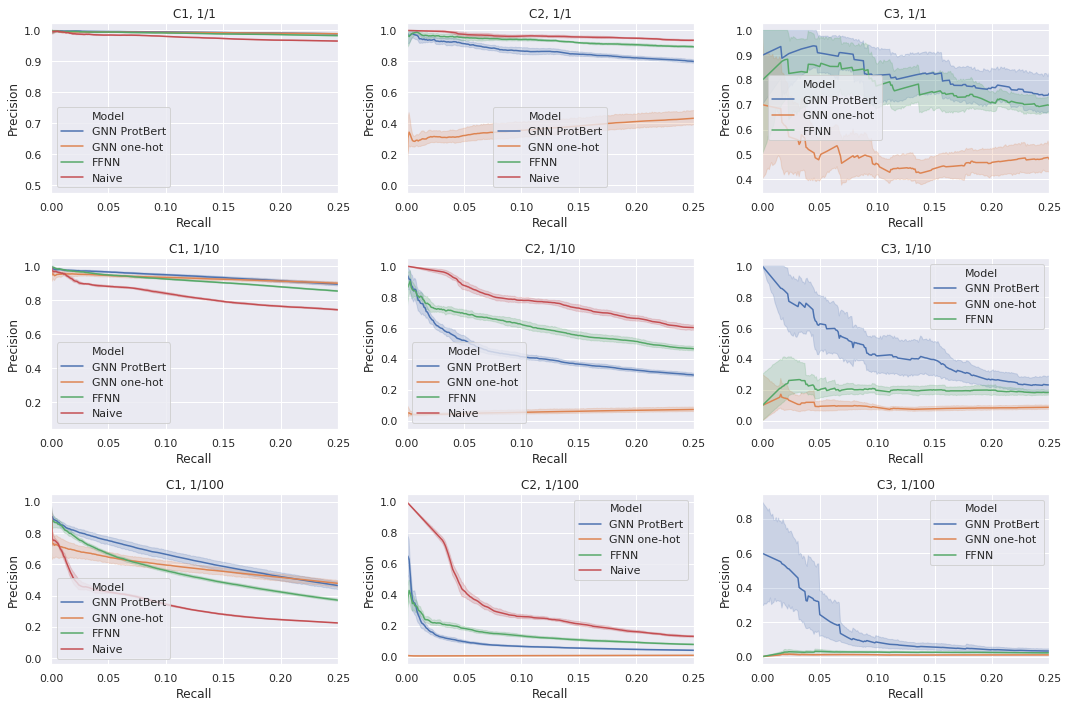

In [39]:
sns.set()
plt.tight_layout()
fig, axs = plt.subplots(3, 3, figsize=(15,10))
titles = ['C1, 1/1', 'C1, 1/10', 'C1, 1/100',\
          'C2, 1/1', 'C2, 1/10', 'C2, 1/100',\
          'C3, 1/1', 'C3, 1/10', 'C3, 1/100']

data = [data_c1_1, data_c1_10, data_c1_100,\
        data_c2_1, data_c2_10, data_c2_100,\
        data_c3_1, data_c3_10, data_c3_100,]

for i in range(3):
    for j in range(3):
        k = j*3+i
        sns.lineplot(data=data[k], x='Recall', y='Precision', hue='Model', ax=axs[i,j])
        axs[i,j].set_title(titles[k])
        axs[i,j].set_xlim(0,0.25)
        
    
fig.tight_layout()
plt.savefig('final.png')
